In [1]:
from sklearn.datasets import load_boston
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error as mse
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import shap
shap.initjs()

In [2]:
### Load Boston Housing data from sklearn
boston = load_boston()
print(boston.keys())
print(boston.feature_names)
print(boston.data.shape)

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])
['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']
(506, 13)


In [3]:
### assign to pandas DF
df_boston = pd.DataFrame(boston.data)
df_boston.columns = boston.feature_names

In [4]:
### set target to column named PRICE
df_boston['PRICE'] = boston.target

In [5]:
### separate target variable and rest of data fields
x, y = df_boston.iloc[:,:-1], df_boston.iloc[:,-1]

In [6]:
### convert dataframe into optimized matrix that XGBoost supports
df_dmatrix = xgb.DMatrix(data=x, label=y)

In [7]:
### create train and test set for cross-validation
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123)

In [8]:
### instatntiate XGBoost regressor (and adust parameters)
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1, max_depth=5, alpha=10, n_estimators=10)

In [9]:
### fit regressor to training set and make predictions, calculate rmse
xg_reg.fit(x_train, y_train)
preds = xg_reg.predict(x_test)
rmse = np.sqrt(mse(y_test, preds))
print(rmse)

10.49602144216164


In [10]:
### what about k-fold validation?
params = {'objective':'reg:squarederror', 'colsample_bytree':0.3, 'learning_rate':0.1, 'max_depth':5, 'alpha':10}
cv_results = xgb.cv(dtrain=df_dmatrix, params=params, nfold=3, num_boost_round=50, early_stopping_rounds=10, metrics='rmse', as_pandas=True, seed=123)
print(cv_results.head())
print((cv_results['test-rmse-mean']).tail(1))

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0        21.679235        0.025628       21.677615       0.050615
1        19.772294        0.016054       19.773321       0.020567
2        18.049566        0.058903       18.065855       0.082745
3        16.430114        0.013613       16.492198       0.020920
4        15.025979        0.062131       15.132644       0.073106
49    3.975679
Name: test-rmse-mean, dtype: float64


In [11]:
### visualization for feature importance
xg_reg = xgb.train(params=params, dtrain=df_dmatrix, num_boost_round=10)

<Figure size 720x432 with 0 Axes>

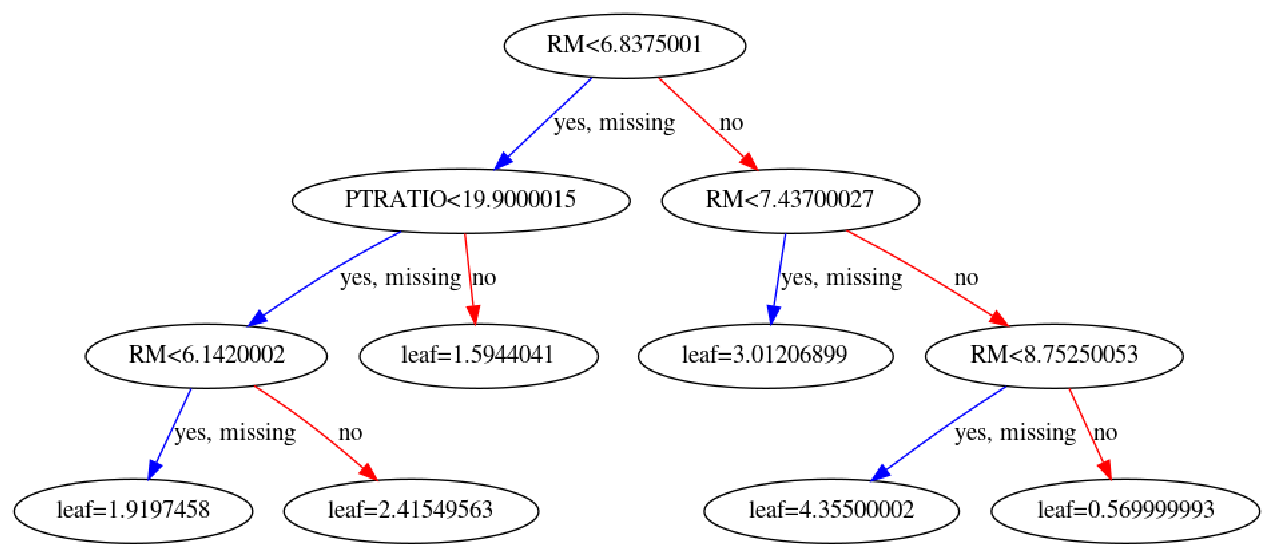

In [20]:
plt.figure(figsize=(10,6))
xgb.plot_tree(xg_reg, num_trees=0)
plt.rcParams['figure.figsize'] = [50, 10]
plt.show()

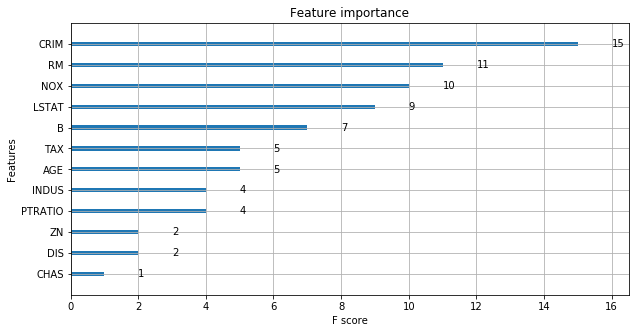

In [18]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [14]:
### explore features with shap
explainer = shap.TreeExplainer(xg_reg)
shap_values = explainer.shap_values(x)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [15]:
### how did features impact prediction for record [i]?
i=0
shap.force_plot(explainer.expected_value, shap_values[i,:], x.iloc[i,:])

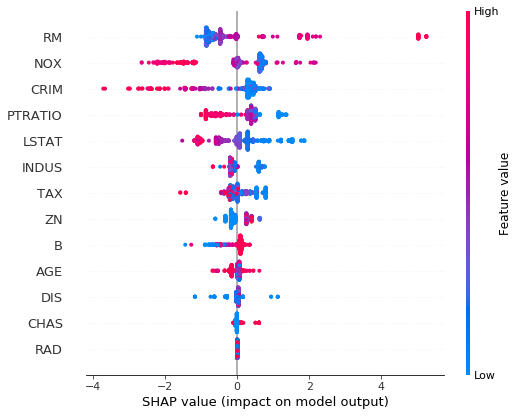

In [16]:
shap.summary_plot(shap_values, x)

In [17]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, x)